In [115]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
customers = pd.read_csv("/mnt/c/users/ankku/downloads/Customers.csv")
transactions = pd.read_csv("/mnt/c/users/ankku/downloads/transactions.csv")

In [117]:
merged_df = pd.merge(transactions, customers, on='CustomerID')
merged_df


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11


In [118]:
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])

I am using following features for clustering:
1. <b>Recency</b>: It shows how recently a customer has bought or make a purchase (in days)
2. <b>Frequency</b>: It shows number of Transactions per customer
3. <b>Monetary Value</b>: It shows total value of transactions per customer

In [119]:
recency = merged_df.groupby('CustomerID')['TransactionDate'].max()
recency = (pd.to_datetime('today') - recency).dt.days
recency

CustomerID
C0001     86
C0002     55
C0003    156
C0004     35
C0005     84
        ... 
C0196     43
C0197     31
C0198    115
C0199     93
C0200     47
Name: TransactionDate, Length: 199, dtype: int64

In [120]:
frequency = merged_df.groupby('CustomerID')['TransactionID'].count()
frequency

CustomerID
C0001    5
C0002    4
C0003    4
C0004    8
C0005    3
        ..
C0196    4
C0197    3
C0198    2
C0199    4
C0200    5
Name: TransactionID, Length: 199, dtype: int64

In [121]:
monetary = merged_df.groupby('CustomerID')['TotalValue'].sum()
monetary


CustomerID
C0001    3354.52
C0002    1862.74
C0003    2725.38
C0004    5354.88
C0005    2034.24
          ...   
C0196    4982.88
C0197    1928.65
C0198     931.83
C0199    1979.28
C0200    4758.60
Name: TotalValue, Length: 199, dtype: float64

In [122]:
customer_features = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

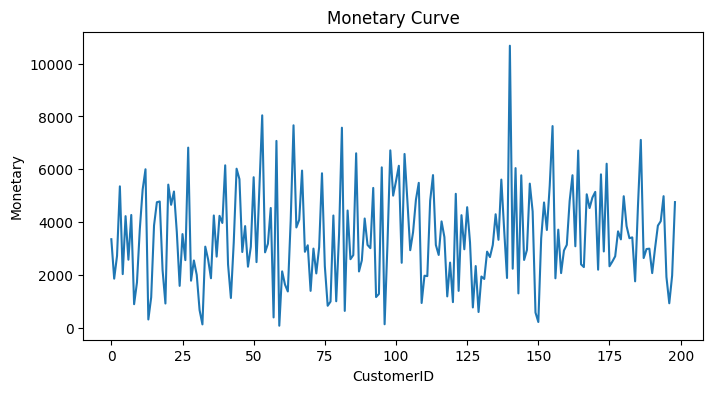

In [123]:
customer_features['Monetary']
plt.figure(figsize=(8, 4))
plt.plot(customer_features.index, customer_features['Monetary'].values)
plt.xlabel("CustomerID")
plt.ylabel("Monetary")
plt.title("Monetary Curve")
plt.show()

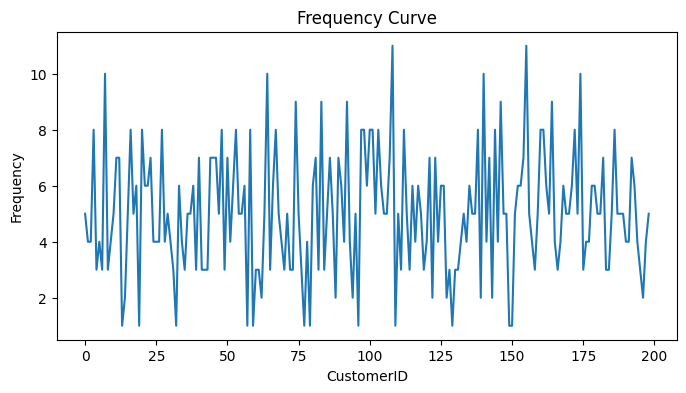

In [124]:
customer_features['Frequency']
plt.figure(figsize=(8, 4))
plt.plot(customer_features.index, customer_features['Frequency'].values)
plt.xlabel("CustomerID")
plt.ylabel("Frequency")
plt.title("Frequency Curve")
plt.show()

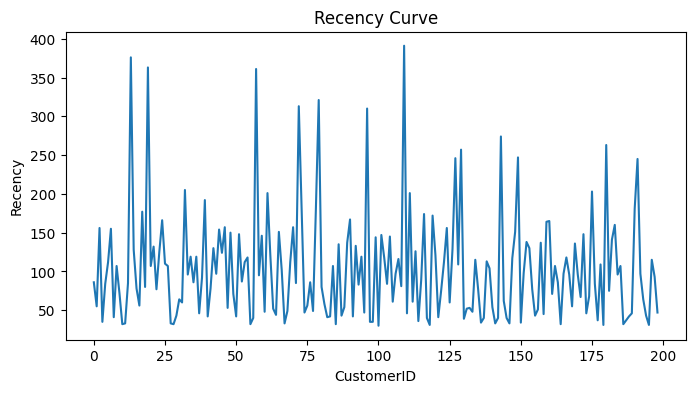

In [125]:
customer_features['Recency']
plt.figure(figsize=(8, 4))
plt.plot(customer_features.index, customer_features['Recency'].values)
plt.xlabel("CustomerID")
plt.ylabel("Recency")
plt.title("Recency Curve")
plt.show()

In [126]:
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(customer_features[['Recency', 'Frequency', 'Monetary']])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features[['Recency', 'Frequency', 'Monetary']])


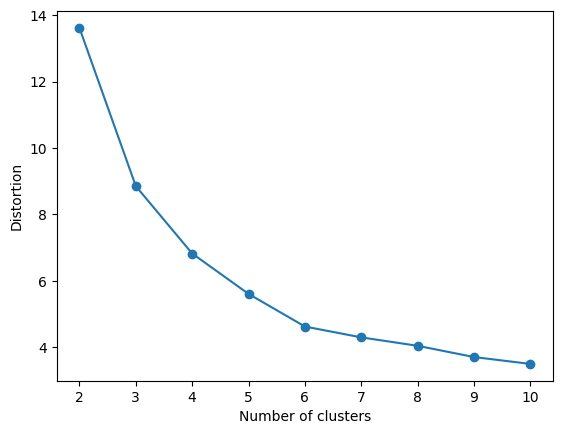

In [127]:
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)

plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [128]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

In [129]:
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])

In [130]:
db_index

np.float64(0.8703645546459836)

In [141]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(scaled_features)

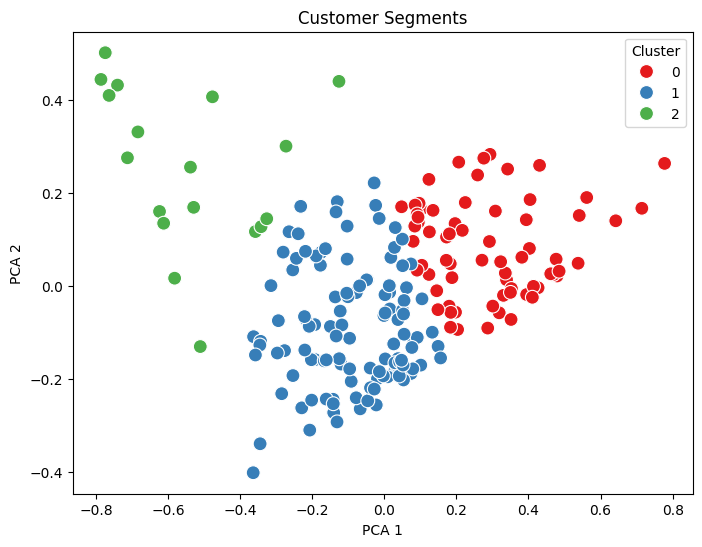

In [142]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_features['Cluster'], palette='Set1', s=100)
plt.title('Customer Segments')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [143]:
customer_features['Cluster'] = kmeans.fit_predict(reduced_features)
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
db_index

np.float64(0.8703645546459836)